In [1]:
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute
from qiskit.circuit import Gate, ControlledGate
from qiskit.visualization import plot_histogram, plot_state_qsphere
%matplotlib inline

In [2]:
event_sim = Aer.get_backend('qasm_simulator')
state_sim = Aer.get_backend('statevector_simulator')

### Generating a GHZ state

In [3]:
qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(3, 'c')

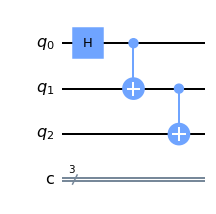

In [4]:
ghz_circuit = QuantumCircuit(qr, cr)
ghz_circuit.h(qr[0])
ghz_circuit.cx(qr[0], qr[1])
ghz_circuit.cx(qr[1], qr[2])

ghz_circuit.draw(output = 'mpl')

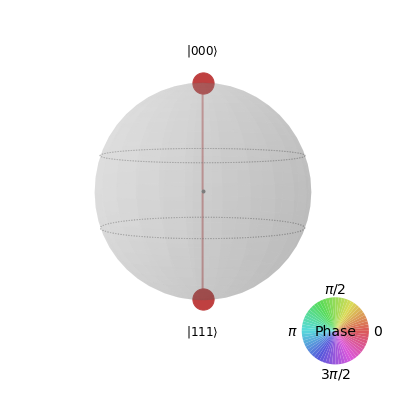

In [5]:
final_state = execute(ghz_circuit, backend = state_sim).result()
plot_state_qsphere(final_state.get_statevector())

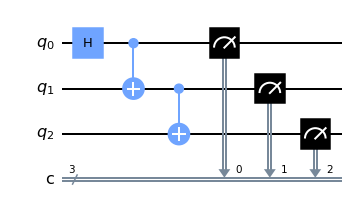

In [6]:
ghz_circuit.measure(qr, cr)
ghz_circuit.draw(output = 'mpl')

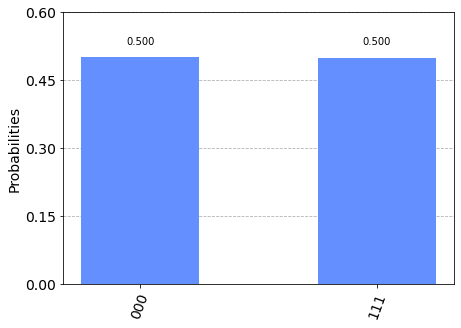

In [7]:
event_results = execute(ghz_circuit, backend = event_sim, shots = 800000).result()
plot_histogram(event_results.get_counts())

### Deutsch Algorithm

In [8]:
def deutschOracle(circuit, qubit, oracle_type, ctrl_qubit = None):
    if (oracle_type not in ['constant', 'balanced']):
        raise AttributeError("'oracle_type' value must be: 'constant' or 'balanced'")
    coin_flip = np.random.randint(2)
    
    if (oracle_type == 'constant'):
        if (coin_flip == 0):
            print('oracle function: f(x) = 0')
            return circuit.i(qubit)
        else:
            print('oracle function: f(x) = 1')
            return circuit.x(qubit)
    elif (oracle_type == 'balanced'):
        if (ctrl_qubit == None):
            raise AttributeError('Balanced oracles request a control qubit.')
        
        if (coin_flip == 0):
            print('oracle function: f(x) = x')
            return circuit.cx(ctrl_qubit, qubit)
        else:
            print('oracle function: f(x) = (x + 1) mod 2')
            circuit.x(qubit)
            return circuit.cx(ctrl_qubit, qubit)

oracle function: f(x) = (x + 1) mod 2


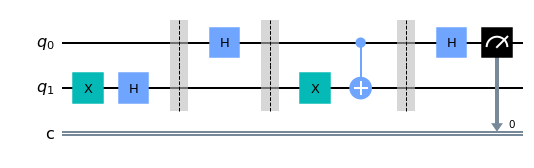

In [11]:
deutsch = QuantumCircuit(2, 1)
deutsch.x(1)
deutsch.h(1)
deutsch.barrier()
deutsch.h(0)
deutsch.barrier()
deutschOracle(deutsch, ctrl_qubit = 0, qubit = 1, oracle_type = 'balanced')
deutsch.barrier()
deutsch.h(0)
deutsch.measure(0, 0)

deutsch.draw(output = 'mpl')

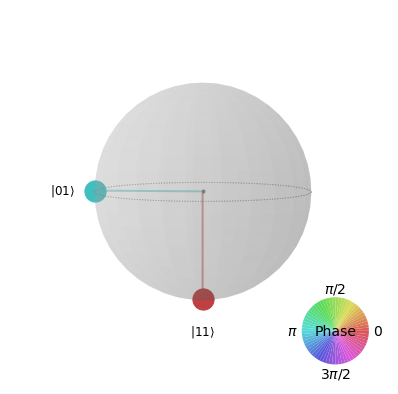

In [12]:
plot_state_qsphere((execute(deutsch, backend = state_sim).result()).get_statevector())

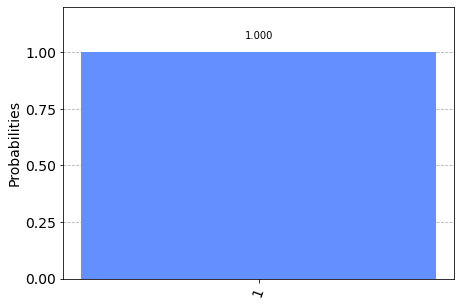

In [13]:
plot_histogram((execute(deutsch, backend = event_sim).result()).get_counts())

### Deutsch-Jozsa Algorithm

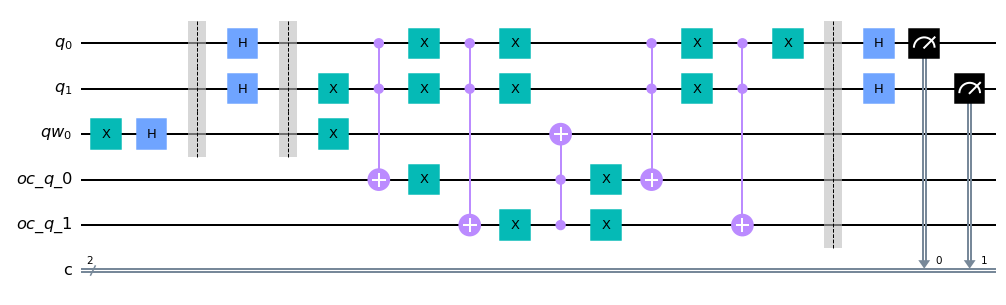

In [14]:
from qiskit.aqua.components.oracles import LogicalExpressionOracle
orc = LogicalExpressionOracle('a XOR b', optimization = False)

n_dj = len(orc.variable_register)
control_qr_dj = QuantumRegister(n_dj, 'q')
working_qr_dj = QuantumRegister(1, 'qw')
cr_dj = ClassicalRegister(n_dj, 'c')

deutsch_jozsa = QuantumCircuit(control_qr_dj, working_qr_dj, cr_dj)
deutsch_jozsa.x(working_qr_dj)
deutsch_jozsa.h(working_qr_dj)
deutsch_jozsa.barrier()
deutsch_jozsa.h(control_qr_dj)
deutsch_jozsa.barrier()

len_anc = 0
len_extra_q = 0
anc_idx = []
extra_q_idx = []

if (orc.ancillary_register != None):
    len_anc = len(orc.ancillary_register)

q_oracle_len = len(orc.circuit.qubits) - len_anc
if (q_oracle_len > n_dj + 1):
    len_extra_q = q_oracle_len - (n_dj + 1)
    extra_q_idx = list(range(n_dj + 1, n_dj + 1 + len_extra_q))
    deutsch_jozsa.add_register(QuantumRegister(len_extra_q, 'oc_q'))
    
if (orc.ancillary_register != None):
    anc_idx = list(range(n_dj + 1 + len_extra_q, n_dj + 1 + len_extra_q + len_anc))
    deutsch_jozsa.add_register(orc.ancillary_register)

var_idx = list(range(0, n_dj))
out_idx = list(range(n_dj, n_dj + 1))
compose_indexing = var_idx + extra_q_idx + out_idx + anc_idx

deutsch_jozsa.compose(orc.construct_circuit(),
                      compose_indexing,
                      inplace = True)
# for indx in range(0, n_dj):
#     deutsch_jozsa.cx(control_qr_dj[indx], working_qr_dj)

deutsch_jozsa.barrier()
deutsch_jozsa.h(control_qr_dj)
deutsch_jozsa.measure(control_qr_dj, cr_dj)

deutsch_jozsa.draw(output = 'mpl')

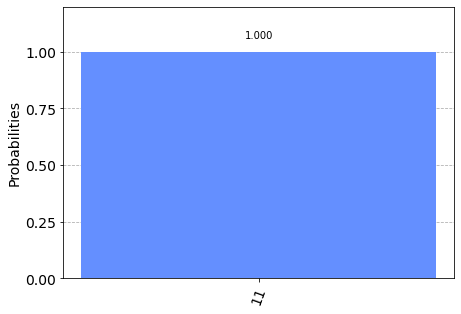

In [15]:
plot_histogram((execute(deutsch_jozsa, backend = event_sim).result()).get_counts())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/qiskit/aqua/algorithms/education/deutsch_jozsa.py:100: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  self._circuit = qc_preoracle + qc_oracle + qc_postoracle
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


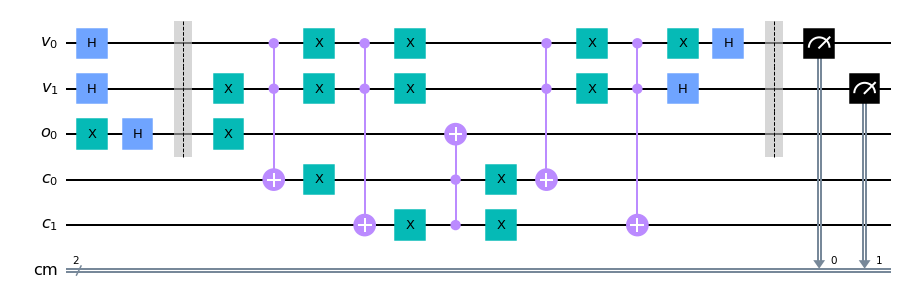

In [16]:
from qiskit.aqua.algorithms import DeutschJozsa

dj_circuit = DeutschJozsa(orc).construct_circuit()

measure_reg = ClassicalRegister(len(orc.variable_register), 'cm')
dj_circuit.add_register(measure_reg)
dj_circuit.measure(orc.variable_register, measure_reg)

dj_circuit.draw('mpl')

### to-do list
#### > Teleportation (several algorithms...)
#### > Simon's Algorithm
#### > Shor's Algorithm
#### > Grover's Algorithm
#### > Quantum Spy Hunter
#### > Quantum error-correcting code